In [ ]:
import os
import torchaudio
import IPython
import requests
import torch
import torchaudio
import numpy as np

def wav2vec_2(wav,sr):
    torch.random.manual_seed(123)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bundle = torchaudio.pipelines.WAV2VEC2_BASE
    model = bundle.get_model().to(device)
    waveform, sample_rate =wav ,sr
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    with torch.inference_mode():
        features, _ = model(waveform)

        
    #stddev_features = np.std(features.cpu().numpy(), axis=0)
    return features

In [ ]:
import dill

import numpy as np
def ph_norm(ph_note):#norm to 0~1
    ph_note_np = np.array(ph_note)
    ph_min = np.min(ph_note_np)
    ph_max = np.max(ph_note_np)
    ph_norm = (ph_note_np - ph_min) / (ph_max - ph_min)
    return  ph_norm.tolist()
#val set
data_path=  'D:/DAMP/Research/dilldata/val_1.dill'
data1 = dill.load(open(data_path, 'rb')) #list
data_path=  'D:/DAMP/Research/dilldata/w2v_CRNN_val_1.dill'
data2 = dill.load(open(data_path, 'rb')) #list
data = data1
for i in range(len(data)):
    data[i]['pitch_histogram']=ph_norm(data[i]['pitch_histogram'])
    data[i]['pitch_histogram']+=data2[i]['w2v_2']
    
train_dill = open('D:/DAMP/Research/dilldata/w2v_ph_val_1.dill', 'wb') 
dill.dump(data, train_dill)
train_dill.close()


#test set
data_path=  'D:/DAMP/Research/dilldata/test_1.dill'
data1 = dill.load(open(data_path, 'rb')) #list
data_path=  'D:/DAMP/Research/dilldata/w2v_CRNN_test_1.dill'
data2 = dill.load(open(data_path, 'rb')) #list
data = data1
for i in range(len(data)):
    data[i]['pitch_histogram']=ph_norm(data[i]['pitch_histogram'])
    data[i]['pitch_histogram']+=data2[i]['w2v_2']
    
train_dill = open('D:/DAMP/Research/dilldata/w2v_ph_test_1.dill', 'wb') 
dill.dump(data, train_dill)
train_dill.close()

#train set
data_path=  'D:/DAMP/Research/dilldata/train_1.dill'
data1 = dill.load(open(data_path, 'rb')) #list
data_path=  'D:/DAMP/Research/dilldata/w2v_CRNN_train_1.dill'
data2 = dill.load(open(data_path, 'rb')) #list
data = data1
for i in range(len(data)):
    data[i]['pitch_histogram']=ph_norm(data[i]['pitch_histogram'])
    data[i]['pitch_histogram']+=data2[i]['w2v_2']
    
train_dill = open('D:/DAMP/Research/dilldata/w2v_ph_train_1.dill', 'wb') 
dill.dump(data, train_dill)
train_dill.close()



In [ ]:
##      train w2v_ph  ##

import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import time
import numpy as np
from torch import nn
from torch.autograd import Variable
from models.SpectralCRNN_hybrid import SpectralCRNN_Reg_Dropout_CQT_w2v_ph as SpectralCRNN
from tensorboard_logger import configure, log_value
from dataLoaders.SpectralDataset_w2v_ph import SpectralDataset, SpectralDataLoader
from sklearn import metrics
from torch.optim import lr_scheduler
from scipy.stats import pearsonr as pearsoncorr
from scipy.stats import spearmanr as spearmancorr
import pdb
import random



# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def evaluate_classification(targets, predictions):
    r2 = metrics.r2_score(targets, predictions)
    predictions[predictions < -1] = -1
    predictions[predictions > 1] = 1
    pearson = pearsoncorr(targets.flatten(), predictions.flatten())
    pearson_corre = pearson[0]
    spearman = spearmancorr(targets.flatten(), predictions.flatten())
    print(f'Pearson Corr =  {pearson_corre:9.5f},  P-value = {pearson[1]}')
    print(f"Spearman Corr =  {spearman[0]:7.5f},  P-value =  {spearman[1]}")
    print(f"R2 =  {r2:7.5f}") #r2->1
    return r2, pearson_corre,spearman[0]

def main():
    # Configure tensorboard logger
    configure('runs/CQT_CRNN_w2v_ph', flush_secs=2)  
    ###Anoconda Prompt:  tensorboard --logdir D:\DAMP\Research\runs\CQT_CRNN_w2v_ph --port 12

    #Parameteres for Spectral Representation
    rep_params = {'method': 'CQT', 'hop_length': 512, 'n_bins': 96, 'bins_per_octave': 24, 'normalize': True}

    # Load Datasets
    train_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_ph_train_1.dill', 0, rep_params)
    train_dataloader = SpectralDataLoader(train_dataset, batch_size=5, num_workers=4, shuffle=True)
    # pdb.set_trace()

    # test_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_CRNN_test_1.dill', 0, rep_params)
    # test_dataloader = SpectralDataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)

    valid_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_ph_val_1.dill', 0, rep_params)
    valid_dataloader = SpectralDataLoader(valid_dataset, batch_size=1, num_workers=1, shuffle=True)

    # Define Model
    model = SpectralCRNN().cuda()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)

    batch_time = AverageMeter()
    data_time = AverageMeter()

    train_loss = 0
    validation_loss = 0

    num_epochs = 250 #250
    best_val_r2 = 0.0
    best_val_corr = 0.0
    epoch_time = time.time()
    for epoch in range(num_epochs):
        print('\n')
        print('Epoch:', epoch)
        print('training set: ')
        model.train()
        # scheduler.step()
        avg_loss = 0.0
        end = time.time()
        all_predictions_all = []
        all_predictions_ps = []
        all_targets = []
        losses = AverageMeter()
        for i, (data) in enumerate(train_dataloader):
            inputs, targets, ph_notes = data
            #inputs, targets, ph_notes,pitchscore = data
            data_time.update(time.time() - end)
            inputs = Variable(inputs.cuda(), requires_grad=False)
            targets = Variable(targets.cuda(), requires_grad=False)
            targets = targets.view(-1, 1)
           # print(targets)
            # pitchscore = Variable(pitchscore.cuda(), requires_grad=False)
            # pitchscore = pitchscore.view(-1, 1)
            
            PH = Variable(ph_notes.cuda(), requires_grad=False)
            model.init_hidden(inputs.size(0))
            result,_ = model(inputs, PH)
           # out_all = result.view(-1,1)
            out_all = result[:,:1].view(-1,1)
            #print(out_all)
            all_predictions_all.extend(out_all.data.cpu().numpy())
            all_targets.extend(targets.data.cpu().numpy())

            
            loss = criterion(out_all, targets) 
            loss_value = loss.data
            losses.update(loss_value, inputs.size(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_time.update(time.time() - end)
            end = time.time()
        train_loss = losses.avg
        train_r2, train_pearson, train_spearman = evaluate_classification(np.array(all_targets), np.array(all_predictions_all))

        print('validation set: ')
        model.eval()
        losses = AverageMeter()
        all_predictions = []
        all_targets = []
        for i, (data) in enumerate(valid_dataloader):
            inputs, targets, ph_notes = data
            data_time.update(time.time() - end)
            inputs = Variable(inputs.cuda(), requires_grad=False)
            targets = Variable(targets.cuda(), requires_grad=False)
            targets = targets.view(-1, 1)
           # print(targets)
            PH = Variable(ph_notes.cuda(), requires_grad=False)
            model.init_hidden(inputs.size(0))
            result,_= model(inputs, PH)
            #out = result.view(-1,1)
            out = result
            
           # out = model(inputs, PH)[0][0].view(-1,1)
            all_predictions.extend(out.data.cpu().numpy())
            all_targets.extend(targets.data.cpu().numpy())
            
            loss = criterion(out, targets)
            loss_value = loss.data
            losses.update(loss_value, inputs.size(0))
        valid_loss = losses.avg
        val_r2, val_pearson,val_spearman = evaluate_classification(np.array(all_targets), np.array(all_predictions))
        print('Train Loss', train_loss, epoch)
        print('Validation Loss', valid_loss, epoch)
        log_value('Train Loss', train_loss, epoch)
        log_value('Validation Loss', valid_loss, epoch)
        log_value('Training R2', train_r2, epoch)
        log_value('Validation R2', val_r2, epoch)
        log_value('Training Spearman Corr ', train_spearman, epoch)
        log_value('Validation Spearman Corr ', val_spearman, epoch)
        log_value('Training Pearson Corr ', train_pearson, epoch)
        log_value('Validation Pearson Corr ', val_pearson, epoch)
    # if val_r2 > best_val_r2:
        # print('Training R2', train_r2, epoch)
        # print('Validation R2', val_r2, epoch)
        # if val_r2 > best_val_r2:
        #     best_val_r2 = val_r2
        #     print('save r2 model')
        #     torch.save(model, './models_hybrid/model_SpectralCRNN_reg_lr0.0001_big_ELU_Adam_noteacc_bws-1to1_CQT_ph_r2')

        if val_pearson > best_val_corr:
            best_val_corr = val_pearson
            print('save pearson corr model: ')
            torch.save(model, './models_hybrid/w2v_ph_CQT_CRNN')
    


if __name__=='__main__':
    main()



In [ ]:
#test

import torch
import time
import numpy as np
from torch import nn
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from torch.autograd import Variable
from sklearn import metrics
from torch.optim import lr_scheduler
import dill
from models.SpectralCRNN_hybrid import SpectralCRNN_Reg_Dropout_CQT_w2v_ph as SpectralCRNN
from dataLoaders.SpectralDataset_w2v_ph import SpectralDataset, SpectralDataLoader
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def evaluate_classification(targets, predictions):
    r2 = metrics.r2_score(targets, predictions)
    predictions[predictions < -1] = -1
    predictions[predictions > 1] = 1
    pearson = pearsonr(targets.flatten(), predictions.flatten())
    pearson_corre = pearson[0]
    print("Pearson Corr = ", pearson)
    print("Spearman Corr = ", spearmanr(targets.flatten(), predictions.flatten()))
    print("R2 = ", r2)
    return pearson_corre, predictions, targets

def evaluate_classification(targets, predictions):
    
    r2 = metrics.r2_score(targets, predictions)
    predictions[predictions < -1] = -1
    predictions[predictions > 1] = 1
    pearson = pearsonr(targets.flatten(), predictions.flatten())
    pearson_corre = pearson[0]
    print("Pearson Corr = ", pearson)
    print("Spearman Corr = ", spearmanr(targets.flatten(), predictions.flatten()))
    print("R2 = ", r2)
    return pearson_corre, predictions, targets


def evaluate_model(model, dataloader):
    model.eval()
    losses = AverageMeter()
    all_predictions = []
    all_targets = []
    for i, (data) in enumerate(dataloader):
        inputs, targets, ph_notes = data
        inputs = Variable(inputs.cuda(), requires_grad = False)
        targets = Variable(targets.cuda(), requires_grad = False)
        targets = targets.view(-1,1)
        PH = Variable(ph_notes.cuda(), requires_grad=False)
        model.init_hidden(inputs.size(0))
        out = model(inputs, PH)[0]
        all_predictions.extend(out.data.cpu().numpy())
        all_targets.extend(targets.data.cpu().numpy())
        loss = criterion(out, targets)
        loss_value = loss.data
        losses.update(loss_value, inputs.size(0))
    print('mse = '+ str(losses.avg))
    return evaluate_classification(np.array(all_targets), np.array(all_predictions))

rep_params = {'method': 'CQT', 'hop_length': 512, 'n_bins': 96, 'bins_per_octave': 24, 'normalize': True}
    # Load Datasets
train_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_ph_train_1.dill', 0, rep_params)
train_dataloader = SpectralDataLoader(train_dataset, batch_size=5, num_workers=4, shuffle=True)
#pdb.set_trace()

test_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_ph_test_1.dill', 0, rep_params)
test_dataloader = SpectralDataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)

valid_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_ph_val_1.dill', 0, rep_params)
valid_dataloader = SpectralDataLoader(valid_dataset, batch_size=1, num_workers=1, shuffle=True)

model_path = './models_hybrid/w2v_ph_CQT_CRNN'
model = SpectralCRNN().cuda()
model = torch.load(model_path)

criterion = nn.MSELoss()

print('training set: ')
train_metrics = evaluate_model(model, train_dataloader)
# #dill.dump({'machine': train_metrics[1].flatten(), 'GT': train_metrics[2].flatten()}, open('./abs_outputs/train_cqt_bws0to1.dill', 'wb'))

print('validation set: ')
val_metrics = evaluate_model(model, valid_dataloader)
#dill.dump({'machine': val_metrics[1].flatten(), 'GT': val_metrics[2].flatten()}, open('./abs_outputs/val_cqt_bws0to1.dill', 'wb'))

print('test set: ')
test_metrics = evaluate_model(model, test_dataloader)
#dill.dump({'machine': test_metrics[1].flatten(), 'GT': test_metrics[2].flatten()}, open('./abs_outputs/test_cqt.dill', 'wb'))

In [1]:
#test

import torch
import time
import numpy as np
from torch import nn
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from torch.autograd import Variable
from sklearn import metrics
from torch.optim import lr_scheduler
import dill
from models.SpectralCRNN_hybrid import SpectralCRNN_Reg_Dropout_CQT_w2v_ph as SpectralCRNN
from dataLoaders.SpectralDataset_w2v_ph import SpectralDataset, SpectralDataLoader
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def evaluate_classification(targets, predictions):
    r2 = metrics.r2_score(targets, predictions)
    predictions[predictions < -1] = -1
    predictions[predictions > 1] = 1
    pearson = pearsonr(targets.flatten(), predictions.flatten())
    pearson_corre = pearson[0]
    print("Pearson Corr = ", pearson)
    print("Spearman Corr = ", spearmanr(targets.flatten(), predictions.flatten()))
    print("R2 = ", r2)
    return pearson_corre, predictions, targets




def evaluate_model(model, dataloader):
    model.eval()
    losses = AverageMeter()
    all_predictions = []
    all_targets = []
    for i, (data) in enumerate(dataloader):
        inputs, targets, ph_notes = data
        inputs = Variable(inputs.cuda(), requires_grad = False)
        targets = Variable(targets.cuda(), requires_grad = False)
        targets = targets.view(-1,1)
        PH = Variable(ph_notes.cuda(), requires_grad=False)
        model.init_hidden(inputs.size(0))
        out = model(inputs, PH)[0]
        all_predictions.extend(out.data.cpu().numpy())
        all_targets.extend(targets.data.cpu().numpy())
        loss = criterion(out, targets)
        loss_value = loss.data
        losses.update(loss_value, inputs.size(0))
    print('mse = '+ str(losses.avg))
    return evaluate_classification(np.array(all_targets), np.array(all_predictions))

rep_params = {'method': 'CQT', 'hop_length': 512, 'n_bins': 96, 'bins_per_octave': 24, 'normalize': True}
    # Load Datasets


test_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_ph_test_1.dill', 0, rep_params)
test_dataloader = SpectralDataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)


model_path = './models_hybrid/w2v_ph_CQT_CRNN'
model = SpectralCRNN().cuda()
model = torch.load(model_path)

criterion = nn.MSELoss()

print('test set: ')
test_metrics = evaluate_model(model, test_dataloader)
#dill.dump({'machine': test_metrics[1].flatten(), 'GT': test_metrics[2].flatten()}, open('./

c:\Users\User\anaconda3\envs\ailab\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


test set: 
mse = tensor(0.0727, device='cuda:0')
Pearson Corr =  (0.7911089527441155, 3.8430450713868084e-44)
Spearman Corr =  SpearmanrResult(correlation=0.792647646165745, pvalue=2.0085844847376305e-44)
R2 =  0.6182361059368218


In [11]:
all_predictions
predictions=[]
for i in all_predictions:
    predictions.append(i[0])
all_targets
targets=[]
for i in all_targets:
    targets.append(i[0])


In [1]:
predictions = [0.32202345,
 -0.0651,
 0.088118955,
 0.2153236,
 -0.04414554,
 0.52110755,
 -0.38852668,
 -0.24853392,
 0.101403475,
 -0.13687228,
 -0.15170772,
 0.49884292,
 0.39957547,
 -0.34438884,
 0.17556646,
 -0.28139076,
 -0.37110254,
 0.55711234,
 0.6580218,
 -0.257966,
 0.28272188,
 -0.09647839,
 0.058357853,
 -0.25722963,
 -0.040414233,
 0.15226997,
 0.46096447,
 0.54833484,
 -0.14295492,
 0.19235419,
 -0.008911968,
 -0.43018752,
 0.3322176,
 0.30252904,
 -0.2808063,
 0.6421625,
 -0.15967609,
 0.4681792,
 0.48448336,
 0.50044155,
 -0.105725944,
 0.26633814,
 0.17008093,
 -0.29615736,
 0.19543768,
 0.6294142,
 0.18018977,
 0.55760163,
 -0.43752858,
 -0.22468606,
 0.4743772,
 0.050106693,
 0.36324468,
 0.43457904,
 -0.5112117,
 -0.26322368,
 0.5006136,
 0.36658046,
 -0.2152793,
 0.1853024,
 -0.13556583,
 0.3353129,
 -0.23022337,
 0.2680914,
 -0.06079178,
 -0.24977224,
 0.27173415,
 -0.029132593,
 0.48006925,
 0.016528677,
 -0.6009503,
 -0.1261572,
 0.33569172,
 0.14554667,
 0.3967944,
 -0.164867,
 -0.22540745,
 0.085506916,
 -0.38019818,
 0.42770797,
 -0.17484893,
 0.25228328,
 -0.13971663,
 0.34726503,
 -0.2804322,
 0.4478778,
 -0.25916973,
 0.02085131,
 -0.24277623,
 -0.5143007,
 0.3628926,
 0.4571567,
 -0.18364055,
 0.50175226,
 -0.23396407,
 0.021073543,
 0.20894103,
 -0.12413256,
 -0.06807634,
 -0.4530807,
 0.043804627,
 -0.23164357,
 0.0013203006,
 0.5602846,
 -0.3537901,
 -0.03975869,
 0.028307658,
 -0.33589754,
 0.012758476,
 -0.012717413,
 -0.016583186,
 0.41793844,
 -0.28020003,
 -0.28435022,
 -0.32304883,
 0.13769007,
 0.1262432,
 0.3781997,
 0.21187662,
 0.45960495,
 -0.21967824,
 0.08134681,
 0.021947635,
 -0.12252502,
 0.6032716,
 0.6057637,
 0.4059697,
 0.27332878,
 -0.13490266,
 0.043850098,
 0.35416585,
 0.14211996,
 -0.4118116,
 0.21066,
 -0.42476627,
 -0.15786004,
 0.055491775,
 0.23419479,
 0.37159538,
 0.4861324,
 0.355702,
 0.45802054,
 -0.20969461,
 0.5389466,
 -0.015304908,
 -0.19213258,
 -0.30091882,
 -0.22519828,
 -0.39432847,
 0.2175196,
 -0.49625126,
 -0.22964324,
 -0.40455887,
 -0.077218145,
 -0.05677423,
 -0.30814058,
 0.42697844,
 -0.39452627,
 0.29231858,
 0.073711365,
 -0.41346854,
 0.2549719,
 -0.1076231,
 0.072536975,
 -0.27312547,
 -9.7384676e-05,
 0.12455693,
 -0.33238503,
 0.06523332,
 -0.20727701,
 0.08000685,
 -0.050986134,
 0.0202443,
 -0.05846254,
 0.015430423,
 0.11549139,
 -0.18403122,
 0.29191232,
 0.04615265,
 0.4241346,
 -0.0018991539,
 0.61396664,
 0.23312747,
 -0.23900688,
 -0.14506279,
 0.08165628,
 -0.05230887,
 0.55944854,
 0.3214942,
 0.07135284,
 -0.44505522,
 0.064949304,
 0.5539363,
 -0.50146925,
 -0.32826048,
 0.2130644,
 0.16464181,
 -0.24360028,
 0.61747897,
 -0.129757]

In [2]:
targets = [0.833,
 -0.333,
 -0.043,
 0.292,
 -0.146,
 0.292,
 0.064,
 -0.388,
 0.381,
 -0.443,
 -0.388,
 0.833,
 0.771,
 -0.691,
 0.278,
 -0.388,
 -0.333,
 0.771,
 0.833,
 -0.677,
 0.642,
 -0.146,
 -0.042,
 0.064,
 0.396,
 0.313,
 0.537,
 0.694,
 -0.677,
 0.146,
 -0.043,
 -0.388,
 0.604,
 0.146,
 -0.617,
 0.776,
 -0.449,
 0.14,
 0.14,
 0.537,
 -0.011,
 0.104,
 0.771,
 -0.474,
 0.642,
 0.449,
 -0.208,
 0.567,
 -0.196,
 -0.629,
 0.604,
 -0.208,
 0.381,
 0.381,
 -0.629,
 -0.691,
 0.604,
 0.396,
 -0.245,
 0.694,
 -0.443,
 -0.443,
 -0.011,
 0.449,
 -0.184,
 0.455,
 0.14,
 0.064,
 0.567,
 0.278,
 -0.691,
 -0.122,
 -0.043,
 -0.061,
 0.313,
 -0.691,
 -0.474,
 0.313,
 -0.146,
 0.14,
 -0.184,
 0.642,
 -0.443,
 0.313,
 -0.196,
 0.381,
 -0.146,
 0.258,
 -0.629,
 -0.245,
 0.771,
 0.537,
 -0.333,
 0.292,
 -0.011,
 -0.208,
 0.14,
 0.258,
 -0.042,
 -0.196,
 -0.677,
 0.064,
 -0.306,
 0.776,
 -0.677,
 0.396,
 0.455,
 -0.691,
 -0.449,
 -0.042,
 -0.122,
 0.604,
 -0.122,
 -0.449,
 -0.043,
 -0.306,
 -0.042,
 0.449,
 -0.184,
 0.567,
 0.064,
 -0.306,
 0.396,
 0.258,
 0.567,
 0.776,
 0.642,
 0.455,
 -0.011,
 0.278,
 0.771,
 0.292,
 -0.629,
 0.537,
 -0.388,
 -0.306,
 0.381,
 -0.184,
 0.833,
 0.537,
 0.604,
 0.455,
 -0.443,
 0.694,
 -0.061,
 -0.449,
 -0.011,
 -0.146,
 -0.196,
 0.396,
 -0.245,
 -0.245,
 -0.629,
 0.258,
 -0.245,
 -0.333,
 0.455,
 -0.196,
 0.694,
 0.449,
 -0.617,
 0.833,
 -0.306,
 -0.043,
 -0.474,
 -0.184,
 -0.042,
 -0.449,
 0.146,
 0.104,
 0.292,
 -0.122,
 0.104,
 0.278,
 0.146,
 -0.061,
 -0.333,
 0.567,
 -0.061,
 0.642,
 -0.122,
 0.776,
 0.278,
 -0.474,
 -0.617,
 -0.061,
 0.104,
 0.694,
 -0.208,
 -0.208,
 -0.617,
 0.146,
 0.449,
 -0.677,
 -0.474,
 0.313,
 0.104,
 -0.617,
 0.776,
 0.258]

array([<AxesSubplot:title={'center':'CQT+w2v+PH'}, xlabel='predictions', ylabel='targets'>],
      dtype=object)

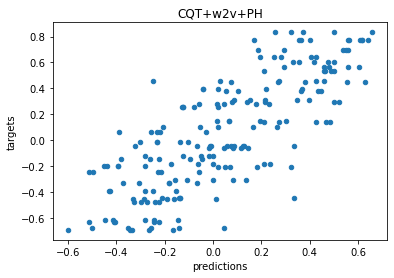

In [10]:
import pandas




dataframe = {"all_predictions":predictions,
        "all_targets":targets,
        }
df = pandas.DataFrame(dataframe)
# colors = {'best singings':'tab:red', 'worst singings':'tab:green'}
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(df['Feature_1'], df['Feature_2'], c=df['label'].map(colors))
# plt.show()

df.plot(title =["CQT+w2v+PH"],subplots=True, x="all_predictions", y="all_targets",xlabel='predictions', ylabel='targets',kind='scatter', colormap='viridis')
